In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [3]:
def grayscale(a):
    return a.reshape(a.shape[0], 3, 32, 32).mean(1).reshape(a.shape[0], -1)

In [4]:
def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

In [5]:
def read_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    for i in range(1, 6):
        filename = '{}/data_batch_{}'.format(directory, i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels


In [6]:
names, data, labels = read_data('./cifar-10-batches-py')
x = tf.placeholder(tf.float32, [None, 24 * 24]) # 5000,576
y = tf.placeholder(tf.float32, [None, len(names)]) # 50000, 10
W1 = tf.Variable(tf.random_normal([5, 5, 1, 64])) # first convo layer with 64 filters size 5x5, one band greyscale, image input size 24x24
b1 = tf.Variable(tf.random_normal([64])) # biases for first convo layer
W2 = tf.Variable(tf.random_normal([5, 5, 64, 64])) # second convo layer with 64 filters size 5x5, run on the 64 outputs of first layer, image input size 12x12
b2 = tf.Variable(tf.random_normal([64])) # biases for the second convo layer
W3 = tf.Variable(tf.random_normal([6*6*64, 1024])) # fully connected layer taking output of convo layer which are 64 image inputs size 6x6 and mapping to 32x32 original image 
b3 = tf.Variable(tf.random_normal([1024])) # biases for fully connected layer
W_out = tf.Variable(tf.random_normal([1024, len(names)])) # output weights for final layer of actual labels, 1024 features  mapped to 10 labels one hot encoded - used for hlf correlations
b_out = tf.Variable(tf.random_normal([len(names)])) # biases for output labels

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)
Instructions for updating:
Colocations handled automatically by placer.


In [7]:
def conv_layer(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_with_b = tf.nn.bias_add(conv, b)
    conv_out = tf.nn.relu(conv_with_b)
    return conv_out

In [8]:
def maxpool_layer(conv, k=2):
    return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1],
     padding='SAME')

In [9]:
def model():
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])
    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)
    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)
    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out

In [10]:
model_op = model()
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y))
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = len(data) // 200
    print('batch size', batch_size)
    for j in tqdm(range(0, 1000)):
        #print('EPOCH', j)
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size, :]
            batch_onehot_vals = onehot_vals[i:i+batch_size, :]
            _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x:batch_data, y: batch_onehot_vals})
            #if i % 1000 == 0:
            #    print(i, accuracy_val)
        #print('DONE WITH EPOCH')
        print(j, accuracy_val)
        

    saver.save(sess, './cifar10-cnn-tf1n-1000epochs.ckpt')

batch size 250


0 0.224
1 0.252
2 0.248
3 0.256
4 0.268
5 0.292
6 0.276
7 0.3
8 0.332
9 0.324
10 0.336
11 0.344
12 0.352
13 0.36
14 0.324
15 0.368
16 0.372
17 0.356
18 0.372
19 0.368
20 0.376
21 0.384
22 0.392
23 0.364
24 0.36
25 0.404
26 0.352
27 0.428
28 0.408
29 0.416
30 0.456
31 0.456
32 0.34
33 0.42
34 0.372
35 0.42
36 0.404
37 0.412
38 0.432
39 0.404
40 0.484
41 0.392
42 0.452
43 0.5
44 0.44
45 0.464
46 0.48
47 0.492
48 0.476
49 0.48
50 0.444
51 0.296
52 0.476
53 0.488
54 0.436
55 0.468
56 0.448
57 0.516
58 0.484
59 0.5
60 0.476
61 0.5
62 0.46
63 0.372
64 0.388
65 0.468
66 0.492
67 0.48
68 0.36
69 0.432
70 0.508
71 0.492
72 0.476
73 0.512
74 0.448
75 0.444
76 0.496
77 0.496
78 0.416
79 0.464
80 0.58
81 0.404
82 0.576
83 0.548
84 0.544
85 0.46
86 0.536
87 0.428
88 0.448
89 0.34
90 0.576
91 0.528
92 0.512
93 0.552
94 0.544
95 0.504
96 0.556
97 0.488
98 0.54
99 0.532
100 0.492
101 0.556
102 0.408
103 0.552
104 0.536
105 0.512
106 0.528
107 0.544
108 0.536
109 0.516
110 0.572
111 0.572
112 0.552
113

851 0.988
852 0.944
853 0.948
854 0.936
855 0.952
856 0.964
857 0.976
858 0.976
859 0.984
860 0.96
861 0.944
862 0.968
863 0.968
864 0.952
865 0.968
866 0.96
867 0.96
868 0.932
869 0.968
870 0.956
871 0.94
872 0.932
873 0.948
874 0.976
875 0.996
876 0.992
877 0.976
878 0.98
879 0.96
880 0.976
881 0.984
882 0.984
883 0.964
884 0.984
885 0.98
886 0.992
887 0.976
888 0.98
889 0.976
890 0.968
891 0.988
892 0.956
893 0.988
894 0.96
895 0.98
896 0.964
897 0.956
898 0.972
899 0.976
900 0.944
901 0.992
902 0.976
903 0.972
904 0.992
905 0.96
906 0.988
907 0.992
908 0.984
909 0.992
910 0.984
911 0.988
912 0.992
913 0.984
914 0.98
915 0.988
916 0.988
917 0.988
918 0.984
919 0.992
920 0.984
921 0.992
922 0.992
923 0.988
924 0.984
925 0.98
926 0.984
927 0.992
928 0.968
929 0.972
930 0.98
931 0.992
932 0.984
933 0.984
934 0.984
935 0.976
936 0.988
937 0.996
938 0.972
939 0.996
940 0.988
941 0.976
942 0.98
943 0.984
944 0.988
945 0.976
946 0.988
947 0.976
948 0.968
949 0.98
950 0.992
951 0.984
952 0.

In [12]:
def model_X(x, W1, b1, W2, b2, W3, b3, W_out, b_out):
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])
    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)
    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.shape[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)
    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out

In [13]:
def predict(img_data):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, "./cifar10-cnn-tf1n-1000epochs.ckpt")
        print("Model restored.")
        W1_val = W1.eval()
        b1_val = b1.eval()
        W2_val = W2.eval()
        b2_val = b2.eval()
        W3_val = W3.eval()
        b3_val = b3.eval()
        W_out_val = W_out.eval()
        b_out_val = b_out.eval()
        model_x_out = model_X(img_data, W1_val, b1_val, W2_val, b2_val, W3_val, b3_val, W_out_val, b_out_val)
        class_num = np.argmax(model_x_out.eval(), axis=1)[0]
        class_name = names[np.argmax(model_x_out.eval(), axis=1)[0]]
        return (class_num, class_name) 

In [14]:
class_num, class_name = predict(data[3])
print('Class Num', class_num)
print('Class', class_name)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-1000epochs.ckpt
Model restored.
Class Num 4
Class deer


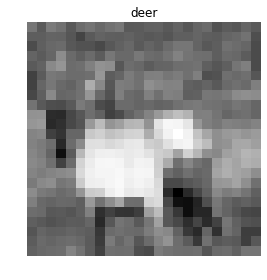

In [15]:
plt.figure()
plt.title(class_name)
img = np.reshape(data[3, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [16]:
# test out on test images
def read_test_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    
    filename = '{}/test_batch'.format(directory)
    batch_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, batch_data['data']))
        labels = np.hstack((labels, batch_data['labels']))
    else:
        data = batch_data['data']
        labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels

In [17]:
test_names, test_data, test_labels = read_test_data('cifar-10-batches-py')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(10000, 3072) (10000,)


In [18]:
test_class_num, test_class_name = predict(test_data[4])
print('Test Class Num', test_class_num)
print('Test Class Name', test_class_name)
print('Actual Class Label', test_labels[4])

INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-1000epochs.ckpt
Model restored.
Test Class Num 6
Test Class Name frog
Actual Class Label 6


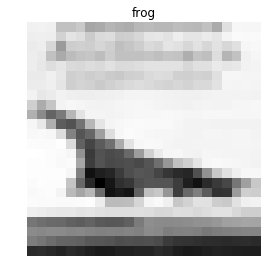

In [19]:
plt.figure()
plt.title(test_class_name)
img = np.reshape(test_data[3, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [20]:
def get_test_accuracy(test_data, test_names, test_labels):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, "./cifar10-cnn-tf1n-1000epochs.ckpt")
        print("Model restored.")
        W1_val = W1.eval()
        b1_val = b1.eval()
        W2_val = W2.eval()
        b2_val = b2.eval()
        W3_val = W3.eval()
        b3_val = b3.eval()
        W_out_val = W_out.eval()
        b_out_val = b_out.eval()
        model_x_out = model_X(test_data, W1_val, b1_val, W2_val, b2_val, W3_val, b3_val, W_out_val, b_out_val)
        
        onehot_test_labels = tf.one_hot(test_labels, len(test_names), on_value=1., off_value=0., axis=-1)
        test_correct_pred = tf.equal(tf.argmax(model_x_out, 1), tf.argmax(onehot_test_labels, 1))
        test_accuracy = tf.reduce_mean(tf.cast(test_correct_pred, tf.float32))
        
        print('Test accuracy %f' % (test_accuracy.eval()))  
        predictions = tf.argmax(model_x_out, 1).eval()
        return (predictions, tf.cast(test_correct_pred, tf.float32).eval(), onehot_test_labels.eval())

    
predict_vals, test_correct_preds, onehot_test_lbls = get_test_accuracy(test_data, test_names, test_labels)
print(predict_vals)
print(predict_vals.shape)
print(test_correct_preds)
print(test_correct_preds.shape)
print(onehot_test_lbls.shape)

INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-1000epochs.ckpt
Model restored.
Test accuracy 0.555100
[6 9 8 ... 5 6 7]
(10000,)
[0. 0. 1. ... 1. 0. 1.]
(10000,)
(10000, 10)


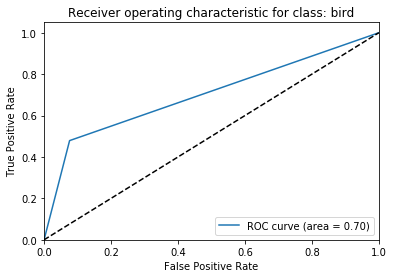

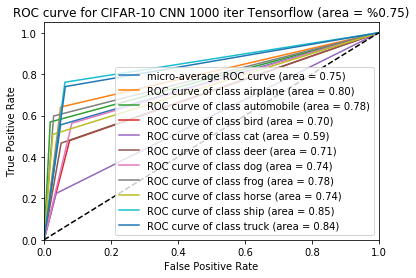

In [21]:
outcome_test = label_binarize(test_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
predictions_test = label_binarize(predict_vals, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#print(outcome_test.shape)
#print(predictions_test.shape)
#print(outcome_test)
#print(predictions_test)
n_classes = outcome_test.shape[1]
#print(n_classes)

#fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
#roc_auc = auc(fpr, tpr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(outcome_test[:, i], predictions_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(outcome_test.ravel(), predictions_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for class: '+test_names[2])
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(test_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
roc_mean = np.mean(np.fromiter(roc_auc.values(), dtype=float))
plt.title('ROC curve for CIFAR-10 CNN 1000 iter Tensorflow (area = %{0:0.2f})'.format(roc_mean))
plt.legend(loc="lower right")
plt.show()